In [22]:
# Core libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyTorch and PyTorch Geometric
import torch
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx

# RDKit for chemical structures
from rdkit import Chem
from rdkit.Chem import rdchem

# Molecule graph visualization
import networkx as nx

# Hugging Face tokenizer
from transformers import AutoTokenizer


## 🔹 Load and check dataset
### Basic info, label distribution, and missing values.


In [4]:
data_path = "./Activate_Inhibit_Raw.csv"
data = pd.read_csv(data_path)

print(data.shape)
print(data.columns)
print(data["label"].unique())
print(data["label"].value_counts())
print(data["label"].values)
print(data.head())
# Check for NaNs in each column
print("Missing values in dataset:\n", data.isna().sum())



(11229, 5)
Index(['drugbank_id', 'SMILES', 'gene_name', 'Sequence', 'label'], dtype='object')
[1 0]
label
0    7907
1    3322
Name: count, dtype: int64
[1 1 1 ... 0 0 0]
  drugbank_id                                             SMILES gene_name  \
0     DB00131  NC1=C2N=CN([C@@H]3O[C@H](COP(O)(O)=O)[C@@H](O)...    PRKAA1   
1     DB00131  NC1=C2N=CN([C@@H]3O[C@H](COP(O)(O)=O)[C@@H](O)...    PRKAA2   
2     DB00131  NC1=C2N=CN([C@@H]3O[C@H](COP(O)(O)=O)[C@@H](O)...    PRKAB1   
3     DB00131  NC1=C2N=CN([C@@H]3O[C@H](COP(O)(O)=O)[C@@H](O)...    PRKAB2   
4     DB00131  NC1=C2N=CN([C@@H]3O[C@H](COP(O)(O)=O)[C@@H](O)...    PRKAG1   

                                            Sequence  label  
0  MRRLSSWRKMATAEKQKHDGRVKIGHYILGDTLGVGTFGKVKVGKH...      1  
1  MAEKQKHDGRVKIGHYVLGDTLGVGTFGKVKIGEHQLTGHKVAVKI...      1  
2  MGNTSSERAALERHGGHKTPRRDSSGGTKDGDRPKILMDSPEDADL...      1  
3  MGNTTSDRVSGERHGAKAARSEGAGGHAPGKEHKIMVGSTDDPSVF...      1  
4  METVISSDSSPAVENEHPQETPESNNSVYTSFMKSHRCYDLIPTSS..

In [5]:
print( "Unique SMILES:", data["SMILES"].nunique())
print( "Unique Protein:", data["Sequence"].nunique())
print( "Unique drugbank_id :", data["drugbank_id"].nunique())
print( "Unique Protein name:", data["gene_name"].nunique())
print(data.groupby("SMILES")["drugbank_id"].nunique().value_counts())


Unique SMILES: 2177
Unique Protein: 1379
Unique drugbank_id : 2183
Unique Protein name: 1376
drugbank_id
1    2176
7       1
Name: count, dtype: int64


In [6]:
# Check protein sequence lengths
data['Sequence_Length'] = data['Sequence'].apply(len)
print("\nProtein Sequence Lengths:")
print(data['Sequence_Length'].describe())
print((data['Sequence_Length']>1024).sum()) ### juicy proteins! too thicc to be tokenized so will get truncated 
# Check for duplicate drug-protein pairs
print("\nDuplicate Drug-Protein Pairs:", data.duplicated(subset=['SMILES', 'Sequence']).sum())


Protein Sequence Lengths:
count    11229.000000
mean       657.983525
std        401.483617
min         23.000000
25%        463.000000
50%        503.000000
75%        660.000000
max       2803.000000
Name: Sequence_Length, dtype: float64
1598

Duplicate Drug-Protein Pairs: 176


## 🔹 Handle duplicates  
### Remove exact duplicates and remove conflicting labels for the same drug–protein pairs.


In [7]:
# Step 1: Drop exact duplicates (SMILES, Sequence, Label) – same as before
data_no_exact_dups = data.drop_duplicates(subset=['SMILES', 'Sequence', 'label'])
print(f"After dropping exact duplicates: {data_no_exact_dups.shape}")  # Should be <= 11229

# Step 2: Find duplicate SMILES-Sequence pairs
duplicate_pairs = data_no_exact_dups[data_no_exact_dups.duplicated(subset=['SMILES', 'Sequence'], keep=False)]
print(f"Number of rows with duplicate SMILES-Sequence pairs: {len(duplicate_pairs)}")

# Step 3: Group by SMILES-Sequence and check label consistency
dup_group = duplicate_pairs.groupby(['SMILES', 'Sequence'])['label'].nunique()
same_label_pairs = dup_group[dup_group == 1].index
conflicting_label_pairs = dup_group[dup_group > 1].index

# Step 4: Count and show results
print(f"Duplicate pairs with same label: {len(same_label_pairs)}")
print(f"Duplicate pairs with conflicting labels: {len(conflicting_label_pairs)}")

# Step 5: Peek at conflicting pairs (optional)
if len(conflicting_label_pairs) > 0:
    print("\nExample conflicting pairs:")
    conflicting_data = duplicate_pairs[duplicate_pairs.set_index(['SMILES', 'Sequence']).index.isin(conflicting_label_pairs)]
    print(conflicting_data.head())



After dropping exact duplicates: (11070, 6)
Number of rows with duplicate SMILES-Sequence pairs: 34
Duplicate pairs with same label: 0
Duplicate pairs with conflicting labels: 17

Example conflicting pairs:
     drugbank_id                                             SMILES gene_name  \
1213     DB01205      CCOC(=O)C1=C2CN(C)C(=O)C3=C(C=CC(F)=C3)N2C=N1    GABRA1   
1217     DB01205      CCOC(=O)C1=C2CN(C)C(=O)C3=C(C=CC(F)=C3)N2C=N1    GABRA5   
1225     DB01205      CCOC(=O)C1=C2CN(C)C(=O)C3=C(C=CC(F)=C3)N2C=N1    GABRG2   
2207     DB13746  CC1=C(C(=O)CC1OC(=O)[C@@H]2[C@H](C2(C)C)C=C(C)...   CACNA1C   
2208     DB13746  CC1=C(C(=O)CC1OC(=O)[C@@H]2[C@H](C2(C)C)C=C(C)...   CACNA1D   

                                               Sequence  label  \
1213  MRKSPGLSDCLWAWILLLSTLTGRSYGQPSLQDELKDNTTVFTRIL...      1   
1217  MDNGMFSGFIMIKNLLLFCISMNLSSHFGFSQMPTSSVKDETNDNI...      1   
1225  MSSPNIWSTGSSVYSTPVFSQKMTVWILLLLSLYPGFTSQKSDDDY...      1   
2207  MVNENTRMYIPEENHQGSNYGSPRPAHANMNANAAA

In [14]:
# Step 1: Drop exact duplicates
data_no_exact_dups = data.drop_duplicates(subset=['SMILES', 'Sequence', 'label'])
print(f"After dropping exact duplicates: {data_no_exact_dups.shape}")

# Step 2: Identify conflicting pairs
duplicate_pairs = data_no_exact_dups[data_no_exact_dups.duplicated(subset=['SMILES', 'Sequence'], keep=False)]
dup_group = duplicate_pairs.groupby(['SMILES', 'Sequence'])['label'].nunique()
conflicting_label_pairs = dup_group[dup_group > 1].index
print(f"Duplicate pairs with conflicting labels: {len(conflicting_label_pairs)}")

# Step 3: Remove all rows with conflicting pairs
data_clean = data_no_exact_dups[~data_no_exact_dups.set_index(['SMILES', 'Sequence']).index.isin(conflicting_label_pairs)]
print(f"After removing conflicting pairs: {data_clean.shape}")

# Step 4: Verify
print(f"Remaining duplicate SMILES-Sequence pairs: {data_clean.duplicated(subset=['SMILES', 'Sequence']).sum()}")
conflict_counts = data_clean.groupby(['SMILES', 'Sequence'])['label'].nunique()
print(f"Conflicting pairs left: {(conflict_counts > 1).sum()}")


After dropping exact duplicates: (11070, 6)
Duplicate pairs with conflicting labels: 17
After removing conflicting pairs: (11036, 6)
Remaining duplicate SMILES-Sequence pairs: 0
Conflicting pairs left: 0


In [15]:
data_clean.to_csv("Activate_Inhibit_Cleaned.csv", index=False)

##  🔹 Train-test split  
### Stratified 80/20 split to preserve label balance across sets


In [16]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data_clean, test_size=0.2, stratify=data_clean["label"], random_state=1)
print("trains set label stats:", train_data["label"].value_counts(normalize=True))
print("test set label stats:", test_data["label"].value_counts(normalize=True))

trains set label stats: label
0    0.706842
1    0.293158
Name: proportion, dtype: float64
test set label stats: label
0    0.706975
1    0.293025
Name: proportion, dtype: float64


In [17]:
overlap = set(train_data.apply(lambda x: (x['SMILES'], x['Sequence']), axis=1)) & set(test_data.apply(lambda x: (x['SMILES'], x['Sequence']), axis=1))
print(f"Number of overlapping drug-protein pairs: {len(overlap)}")
print("All SMILES valid strings:", data_clean['SMILES'].apply(lambda x: isinstance(x, str) and len(x) > 0).all())

Number of overlapping drug-protein pairs: 0
All SMILES valid strings: True


## 🔹 Convert drug SMILES to molecular graph  
### Transforms a SMILES string into a molecular graph with node and edge features for use in a GNN:
- ### **Node features**: atomic number, degree, aromaticity, hybridization  
- ### **Edge features**: bond type (single, double, triple, aromatic)


In [18]:


def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None  # Return None for invalid SMILES
    
    # Node features (atoms)
    node_features = []
    for atom in mol.GetAtoms():
        node_features.append([
            atom.GetAtomicNum(),  # Atomic number
            atom.GetDegree(),  # Number of bonds
            int(atom.GetIsAromatic()),  # Aromaticity
            atom.GetHybridization().real  # Hybridization state
        ])
    
    # Edges (bonds)
    edge_index = []
    edge_features = []
    for bond in mol.GetBonds():
        start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        edge_index.append([start, end])
        edge_index.append([end, start])  # Reverse direction
        
        # Bond features (Type: Single, Double, Triple, Aromatic)
        bond_type = bond.GetBondType()
        bond_feature = [
            int(bond_type == Chem.rdchem.BondType.SINGLE),
            int(bond_type == Chem.rdchem.BondType.DOUBLE),
            int(bond_type == Chem.rdchem.BondType.TRIPLE),
            int(bond_type == Chem.rdchem.BondType.AROMATIC)
        ]
        
        edge_features.append(bond_feature)
        edge_features.append(bond_feature)  # Reverse edge
    
    # Convert to PyTorch tensors
    x = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_features, dtype=torch.float)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

# Example usage
smiles = "CCO"  # Ethanol
graph = smiles_to_graph(smiles)

print(graph)


Data(x=[3, 4], edge_index=[2, 4], edge_attr=[4, 4])



### Convert SMILES to PyTorch Geometric graphs and store them as `.pt` files


In [19]:
# Create the folder
os.makedirs("Train_Test_Data", exist_ok=True)

# Generate and save graphs
train_graphs = [smiles_to_graph(x) for x in train_data["SMILES"] if x]
test_graphs = [smiles_to_graph(x) for x in test_data["SMILES"] if x]
torch.save(train_graphs, "Train_Test_Data/train_graphs.pt")
torch.save(test_graphs, "Train_Test_Data/test_graphs.pt")


## 🔹 Tokenized protein sequences using ESM2
### Tokenize protein sequences using ESM2 and save the encoded tensors as `.pt` files

In [20]:

tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")

train_tokens = [tokenizer(seq, truncation=True, padding=True, max_length=1024, return_tensors="pt") for seq in train_data["Sequence"]]
test_tokens = [tokenizer(seq, truncation=True, padding=True, max_length=1024, return_tensors="pt") for seq in test_data["Sequence"]]
torch.save(train_tokens, "Train_Test_Data/train_tokens.pt")
torch.save(test_tokens, "Train_Test_Data/test_tokens.pt")


## 🔹 Save train/test labels


In [21]:

# Save tabular data (no Graph or Tokens columns)
train_data[["SMILES", "Sequence", "label"]].to_csv("Train_Test_Data/train.csv", index=False)
test_data[["SMILES", "Sequence", "label"]].to_csv("Train_Test_Data/test.csv", index=False)

# Verify
print(f"Train graphs: {len(train_graphs)}, Test graphs: {len(test_graphs)}")
print(f"Train tokens: {len(train_tokens)}, Test tokens: {len(test_tokens)}")
print(train_data.columns)
print(os.listdir("Train_Test_Data"))

Train graphs: 8828, Test graphs: 2208
Train tokens: 8828, Test tokens: 2208
Index(['drugbank_id', 'SMILES', 'gene_name', 'Sequence', 'label',
       'Sequence_Length'],
      dtype='object')
['train_graphs.pt', 'test.csv', 'test_tokens.pt', 'train_tokens.pt', 'train.csv', 'test_graphs.pt']


### 🔹 Visualizing Molecular Graph  

New train_data index: RangeIndex(start=0, stop=8828, step=1)
SMILES for drug #4: CN1C2=C(C=C(Cl)C=C2)C2(OC(C)=CC(=O)N2CC1=O)C1=CC=CC=C1
Converted NetworkX Graph:
Nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
Edges: [(0, 1), (1, 2), (1, 18), (2, 3), (2, 8), (3, 4), (3, 9), (4, 5), (5, 6), (5, 7), (7, 8), (9, 10), (9, 20), (9, 16), (10, 11), (11, 12), (11, 13), (13, 14), (14, 15), (14, 16), (16, 17), (17, 18), (18, 19), (20, 21), (20, 25), (21, 22), (22, 23), (23, 24), (24, 25)]


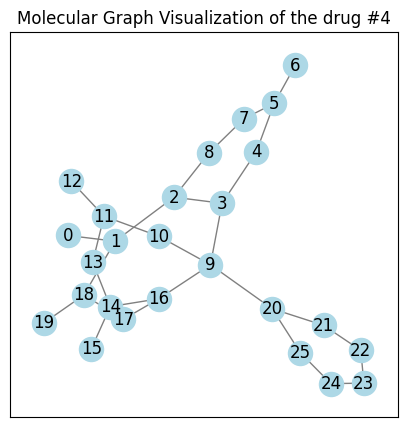

In [15]:

train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

# Verify the new index
print("New train_data index:", train_data.index)

# Now get the SMILES for drug #4
smiles = train_data["SMILES"][3]
print(f"SMILES for drug #4: {smiles}")

# Your visualization (unchanged)
graph_data = train_graphs[3]
if graph_data is None:
    print("Graph data is None. Cannot visualize.")
else:
    G = to_networkx(graph_data, to_undirected=True)
    print("Converted NetworkX Graph:")
    print(f"Nodes: {G.nodes()}")
    print(f"Edges: {G.edges()}")
    pos = nx.spring_layout(G)
    plt.figure(figsize=(5, 5))
    nx.draw_networkx(G, pos, with_labels=True, node_size=300, node_color="lightblue", edge_color="gray")
    plt.title("Molecular Graph Visualization of the drug #4")
    plt.show()